In [1]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from consent.consistency.comply_util import site_to_contras, get_comply
from consent.consistency.cookie_pref_match import cookie_pref_match
from consent.consistency.util import get_scan_root_dir, get_scan_dirs # , FIG_DIR uncomment to save fig.
from consent.data.pref_menu_scan.cookie_pref_reader import read_cookie_prefs_in_scans
from consent.data.pref_menu_scan.har_cookie_reader import read_postrej_sent_cookies_in_scans

overwrite = True
SCAN_ROOT_DIR = Path('/mnt/sdd/ducbui/projects/data2/consent/2023-04-08/') # get_scan_root_dir('us')
SCAN_DIRS = [SCAN_ROOT_DIR / 'pref_menu_scan']
# SCAN_DIRS = get_scan_dirs('us')[:]
output_suffix = '_' + '0k_20k'  # '20k_100k' #'60k_80k' # '40k_60k' # # '100k_200k'; done: '20k_40k' '0k_20k' 
print(SCAN_ROOT_DIR)
SCAN_DIRS

/mnt/sdd/ducbui/projects/data2/consent/2023-04-08


[PosixPath('/mnt/sdd/ducbui/projects/data2/consent/2023-04-08/pref_menu_scan')]

In [4]:
# Get cookie prefs = cookie decls + prefs
cookie_prefs_file = SCAN_ROOT_DIR / f'cookie_prefs{output_suffix}.parquet'

if not cookie_prefs_file.exists() or overwrite:
    save_cookie_decls_file = None # TODO: SCAN_ROOT_DIR / f'cookie_decls{output_suffix}.parquet'
    cookie_prefs = read_cookie_prefs_in_scans(SCAN_DIRS, save_cookie_decls_file)  # took 2.3min for top 50k-site scan
    cookie_prefs.to_parquet(cookie_prefs_file); print(f'Written to {cookie_prefs_file}')
else:
    cookie_prefs = pd.read_parquet(cookie_prefs_file)
cookie_prefs.head() 
# TODO: add log_file_checker


https://cdn.cookielaw.org/consent/97c4dcf9-39b5-41a7-b88b-69c94baa35f1/8e5748b1-d445-4820-b75e-5a96c83cb90b/en.json WARNING: Cookie list has session cookie but duration > 0
https://cdn.cookielaw.org/consent/cadb9218-57dc-4d9d-88e2-9f60895ffd8e/2e90824b-582a-48f2-80e3-28447dbd05d5/en-us.json WARNING: Cookie list has session cookie but duration > 0
https://cdn-ukwest.onetrust.com/consent/86f42b6d-7a31-469c-804c-319643173d42/9d40c5cd-66b0-4350-a7c5-dbf2e950474e/en.json WARNING: Cookie list has session cookie but duration > 0
 consent_js not supported yet.
https://cdn-ukwest.onetrust.com/consent/e4eb3b2e-4cc5-4752-b2ca-381970849659/204361df-8a07-4ca3-a82b-f9c3a0433d38/en.json WARNING: Cookie list has session cookie but duration > 0

UnicodeEncodeError: 'utf-8' codec can't encode characters in position 0-1: surrogates not allowed

In [5]:
print("Found cookie libraries:")
cookie_prefs[['site', 'lib_name']].drop_duplicates().lib_name.value_counts()

Found cookie libraries:


onetrust     1223
cookiebot      86
termly          3
Name: lib_name, dtype: int64

In [6]:
cookielist_sites = sorted(cookie_prefs.site.unique().tolist())
n_cookielist_sites = len(cookielist_sites)
assert cookie_prefs.site.nunique() == n_cookielist_sites
n=10
print("Sites with cookie prefs:", n_cookielist_sites, f', first {n} sites:' , cookielist_sites[:n])

Sites with cookie prefs: 1312 , first 10 sites: ['10best.com', '247sports.com', '2k.com', '90min.com', 'aalto.fi', 'aao.org', 'abbvie.com', 'aber.ac.uk', 'ablebits.com', 'acast.com']


In [7]:
site_to_libname = {row['site']: row['lib_name'] for row in cookie_prefs[['site', 'lib_name']].drop_duplicates().to_dict('records')}

In [8]:
# Quick checking the cookie declaration naming
print(len(cookie_prefs[cookie_prefs.name.str.endswith('#')]) / len(cookie_prefs))
print(len(cookie_prefs[cookie_prefs.name.str.endswith('xxx')]) / len(cookie_prefs))
print(len(cookie_prefs[cookie_prefs.name.str.endswith('XXX')]) / len(cookie_prefs))
cookie_prefs[cookie_prefs.name.str.endswith('#')]

0.011650822655300257
0.022693809131889123
0.002778679674109199


,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
21,_gd#############,j.6sc.co,730 days,C0002,Performance Cookies,always active,wework.com,onetrust,en.json,True
28,_gd#############,www.wework.com,730 days,C0003,Functional Cookies,always active,wework.com,onetrust,en.json,True
32,_gd#############,cdnjs.cloudflare.com,730 days,C0003,Functional Cookies,always active,wework.com,onetrust,en.json,True
16,_hp2_ses_props.##########,lumen.com,0 days,4,Targeting Cookies,active,savvis.net,onetrust,en.json,False
18,_hp2_id.##########,lumen.com,394 days,4,Targeting Cookies,active,savvis.net,onetrust,en.json,False
...,...,...,...,...,...,...,...,...,...,...
134,_gd#############,cdnjs.cloudflare.com,729 days,4,Targeting Cookies,active,outreach.io,onetrust,en.json,False
14,visitor_id#####,www.paymentus.com,3650 days,C0004,Targeting Cookies,inactive,paymentus.com,onetrust,en.json,False
19,visitor_id#####,pi.pardot.com,3650 days,C0004,Targeting Cookies,inactive,paymentus.com,onetrust,en.json,False
24,visitor_id#####,pardot.com,3650 days,C0004,Targeting Cookies,inactive,paymentus.com,onetrust,en.json,False


In [7]:
# # Distribution of errors
# print("Libs in failed-to-crawl sites")
# errors.consent_lib_name.value_counts()
# from ooutil.df_util import expand_dict_col
# ot_errs = errors[errors.consent_lib_name == 'onetrust']
# errors_dict = pd.DataFrame(ot_errs.error.tolist()).explode('reason')
# # Uncomment to show
# # errors_dict.reason.value_counts()

# Main analysis

In [9]:
# import sys; import importlib; importlib.reload(sys.modules['consent.data.pref_menu_scan.postrej_cookie_reader'])
from consent.data.pref_menu_scan.har_cookie_reader import read_postrej_sent_cookies_in_scans

cookies_cache_file = SCAN_ROOT_DIR / f'scan{output_suffix}.parquet'  # 'raw_postrej_sent_cookies.parquet'

if not cookies_cache_file.exists() or overwrite:
    sent_cookies = read_postrej_sent_cookies_in_scans(SCAN_DIRS)
    if cookies_cache_file: sent_cookies.to_parquet(cookies_cache_file); print(f"Written to {cookies_cache_file}")
else:
    sent_cookies = pd.read_parquet(cookies_cache_file)

print(f"Number sent cookies read: {len(sent_cookies):,d}")
sent_cookies.head(3)

Unmatch url and consent cookie domain: page_url='https://www.accuweather.com/en/us/rockledge/32955/current-weather/2245469?lang=en-us&partner=web_gannett_news' consent_cookie.cookie['domain']='.floridatoday.com' consent_cookie.cookie['path']='/' floridatoday.com/postrej_3.har.xz
Error reading har file /mnt/sdd/ducbui/projects/data2/consent/2023-04-08/pref_menu_scan/crucial.com/postrej_2.har.xz: 'DataFrame' object has no attribute 'request'
Unmatch url and consent cookie domain: page_url='https://www.nottinghampost.com/' consent_cookie.cookie['domain']='www.fish4.co.uk' consent_cookie.cookie['path']='/' nottinghampost.com/postrej_0.har.xz
Domain path mismatch: .www.volvocars.com domain's path /us not match url https://www.volvocars.com/es-us/
Unmatch url and consent cookie domain: page_url='https://www.volvocars.com/es-us/' consent_cookie.cookie['domain']='.www.volvocars.com' consent_cookie.cookie['path']='/us' volvocars.com/postrej_3.har.xz
Post rej cookie not contain consent cookie, i

,name,value,domain,path,expires,size,httpOnly,secure,session,sameSite,priority,sameParty,sourceScheme,sourcePort,request_url,site,page_url
0,UID,1520e1cf6bcab3845e57b0f1681034169,.scorecardresearch.com,/,1.715594e+09,36,False,True,False,None,Medium,False,Secure,443,https://sb.scorecardresearch.com/b?c1=7&c2=343...,floridatoday.com,https://www.floridatoday.com/opinions-columns/
1,t_gid,9393ebb0-1241-4dac-964d-90449d28b45d-tuctb2c113a,.taboola.com,/,1.712570e+09,53,False,True,False,None,Medium,False,Secure,443,https://vidstat.taboola.com/uploadedVideos/235...,floridatoday.com,https://www.floridatoday.com/opinions-columns/
2,bku,ZWA999I11ZuLVcRe,.bluekai.com,/,1.696846e+09,19,False,True,False,None,Medium,False,Secure,443,https://tags.bluekai.com/site/18840?&id=cuid_e...,floridatoday.com,https://www.floridatoday.com/opinions-columns/


In [10]:
# prj = post-rejection
# Old way: consider all flows
# prj_sent_cookies = sent_cookies[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'value', 'request_url', 'site']].drop_duplicates()
# prj_br_cookies = prj_sent_cookies[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'site']].drop_duplicates()
# New way: consider cookies only (ignore the request url, which is not nused in get_comply cookie matching anyway)
prj_sent_cookies = sent_cookies[['name', 'domain', 'path', 'site']].drop_duplicates()

In [11]:
# print(f"Num captured sent cookies: {len(sent_cookies):,d}")
# print(f"Num unique captured cookies: {len(prj_sent_cookies):,d}")
# n_br_cookies = len(prj_br_cookies)
# print(f"Num unique browser cookies: {n_br_cookies:,d} on {prj_br_cookies.site.nunique():,d} websites") # and {sent_cookies.page_url.nunique():,d} pages")

## Analyze cookies compliance    

In [12]:
sites = set(cookie_prefs.site)
print(f"Num sent cookies in the cookie prefs sites: {len(prj_sent_cookies[prj_sent_cookies.site.isin(sites)]):,d}")

Num sent cookies in the cookie prefs sites: 66,360


In [13]:
import sys; import importlib; importlib.reload(sys.modules['consent.consistency.comply_util'])
from consent.consistency.comply_util import get_comply

print("faster: for cookie_pref in cookie_pref_set[cookie_pref_set.name == acookie['name']]:")
all_complies = get_comply(cookie_prefs, prj_sent_cookies)
all_complies.head()

faster: for cookie_pref in cookie_pref_set[cookie_pref_set.name == acookie['name']]:


 38%|███▊      | 495/1312 [01:05<00:36, 22.23it/s]

Error fuzzy name match pref_name='csrf[frontend.store-api.proxy]' cookie_name='TS01cb552a' bad character range e-a at position 22
Error fuzzy name match pref_name='csrf[frontend.store-api.proxy]' cookie_name='_fbp' bad character range e-a at position 22
Error fuzzy name match pref_name='csrf[frontend.store-api.proxy]' cookie_name='ln_or' bad character range e-a at position 22
Error fuzzy name match pref_name='csrf[frontend.store-api.proxy]' cookie_name='ret' bad character range e-a at position 22
Error fuzzy name match pref_name='csrf[frontend.store-api.proxy]' cookie_name='OptanonConsent' bad character range e-a at position 22
Error fuzzy name match pref_name='csrf[frontend.store-api.proxy]' cookie_name='UserID1' bad character range e-a at position 22
Error fuzzy name match pref_name='csrf[frontend.store-api.proxy]' cookie_name='_gid' bad character range e-a at position 22
Error fuzzy name match pref_name='csrf[frontend.store-api.proxy]' cookie_name='_ga' bad character range e-a at po

 61%|██████▏   | 805/1312 [01:57<00:47, 10.74it/s]

Big cookie pref jabra.com 4141 skip this site


 63%|██████▎   | 830/1312 [02:04<01:09,  6.93it/s]

Big cookie pref ncl.com 4436 skip this site


100%|█████████▉| 1310/1312 [04:11<00:00,  5.21it/s]


,name,domain,path,site,comply
0,UID,.scorecardresearch.com,/,floridatoday.com,comply
1,t_gid,.taboola.com,/,floridatoday.com,comply
2,bku,.bluekai.com,/,floridatoday.com,comply
3,ad-privacy,.amazon-adsystem.com,/,floridatoday.com,comply
4,__qca,.floridatoday.com,/,floridatoday.com,omit


In [14]:
# Analyze complies here
complies = all_complies[['name', 'domain', 'path', 'site', 'comply']].drop_duplicates()
comply_sites_data = defaultdict(list)
for comply_type, comply_group in complies.groupby('comply'):
    n_sites = comply_group.site.nunique()
    comply_sites_data['comply_type'].append(comply_type)
    comply_sites_data['num_sites'].append(n_sites)
    comply_sites = pd.DataFrame(comply_sites_data).sort_values(by=['num_sites'], ascending=False)
    
nsites = all_complies.site.nunique()
comply_counts = complies.comply.value_counts()
comply_sites['num_sites_percent'] = comply_sites['num_sites'] / nsites * 100
comply_sites['num_cookies'] = comply_sites['comply_type'].map(comply_counts)
comply_sites['num_cookies_percent'] = comply_sites['num_cookies'] / comply_sites['num_cookies'].sum() * 100  # need to read scan_*.parquet for n_br_cookies, but may be unnecessary
comply_sites['num_cookies_per_site'] = comply_sites['num_cookies'] / comply_sites['num_sites'] 

# Do not count comply/correct enforcement: which require detecting all possible
comply_sites = comply_sites[comply_sites.comply_type != 'comply']
comply_sites

,comply_type,num_sites,num_sites_percent,num_cookies,num_cookies_percent,num_cookies_per_site
3,omit,1202,92.107280,38008,57.365371,31.620632
2,incorrect,1018,78.007663,14524,21.921034,14.267191
0,ambiguous,72,5.517241,121,0.182625,1.680556


In [15]:
# Record the analysis results
all_complies_file = SCAN_ROOT_DIR / f'all_complies{output_suffix}.parquet'
all_complies.to_parquet(all_complies_file); print(f"Written {len(all_complies):,d} records of all_complies to {all_complies_file}")

Written 66,256 records of all_complies to /mnt/sdd/ducbui/projects/data2/consent/2023-04-08/all_complies_0k_20k.parquet


In [16]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

In [ ]:
complies.comply

array(['comply', 'omit', 'incorrect', 'ambiguous'], dtype=object)

In [ ]:
nsites = all_complies.site.nunique(); nsites
# all_complies.site.unique()

542

In [ ]:
detected_contra_sites = [s for s, contras in site_to_contras.items() if len(contras) > 0]; len(detected_contra_sites)

56

In [ ]:
complies = all_complies[ ['name', 'domain', 'site', 'comply',]].drop_duplicates()
comply_counts = complies.comply.value_counts()
comply_counts

omit         4238
incorrect    3436
comply       2587
ambiguous      23
Name: comply, dtype: int64

In [ ]:
complies_sites = set(all_complies.site)
sent_cookies_com = sent_cookies[sent_cookies.site.isin(complies_sites)]
prj_sent_cookies_com = sent_cookies_com[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'value', 'request_url', 'site']].drop_duplicates()
prj_br_cookies_com = prj_sent_cookies_com[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'site']].drop_duplicates()
print(f"Num captured sent cookies: {len(sent_cookies_com):,d}")
print(f"Num unique captured cookies: {len(prj_sent_cookies_com):,d}")

n_br_cookies_com = len(prj_br_cookies_com)
print(f"Num unique browser cookies: {n_br_cookies_com:,d} on {prj_br_cookies_com.site.nunique():,d} websites") # and {sent_cookies.page_url.nunique():,d} pages")

Num captured sent cookies: 1,118,195
Num unique captured cookies: 598,285
Num unique browser cookies: 22,396 on 542 websites


# Analyze contras

In [ ]:
# Way 1: compute contra sites by dynamic analysis: this should be lower than statically analyzing prefs
# because we cannot check all combinations of consent modes.
from consent.consistency.comply_util import get_appr_rej_sets
contra_data = []
for asite in cookie_prefs.site.unique():
    site_prefs = cookie_prefs[cookie_prefs.site == asite]
    _, _, contras = get_appr_rej_sets(site_prefs)
    for contra in contras:
        contra['site'] = asite
        contra_data.append(contra)
contra_sites = pd.DataFrame(contra_data)
contra_sites.head()

,domain,name,site
0,beacon.riskified.com,rCookie,benetton.com
1,communities.vmware.com,VISITOR_BEACON,workspaceoneaccess.com
2,communities.vmware.com,LithiumCookiesAccepted,workspaceoneaccess.com
3,careers.paradox.ai,R-GDPR-Applicable,paradox.ai
4,shop.ducati.com,form_key,ducati.com


In [ ]:
assert set(detected_contra_sites) == set(contra_sites.site), "this is the same method with above, so the result"

In [ ]:
set(detected_contra_sites) - set(contra_sites.site)
set(contra_sites.site) - set(detected_contra_sites) 
# This may be the sites excluded due to testing cookies in the preferences.

set()

In [ ]:
# Way 2: compute contra sites by DataFrame group by
contra_cookies_dfs = []
for _, same_cookies in cookie_prefs.groupby(['name', 'domain', 'site']):
    consent_modes = same_cookies.consent_mode.unique()
    if len(consent_modes) >= 2 and same_cookies.category.nunique() > 1: # and 'always active' in consent_modes:
        contra_cookies_dfs.append(same_cookies)
contra_cookies = pd.concat(contra_cookies_dfs).drop_duplicates()

In [ ]:
print("Number sites with contra cookies:", contra_cookies.site.nunique())

Number sites with contra cookies: 74


In [ ]:
# set(contra_cookies.site) - set(contra_sites.site)

In [ ]:
print("Num contra cookie settings (double categories):", len(contra_cookies), f"settings  on {contra_cookies.site.nunique()} sites")
print("Contras with 1 always-active:", contra_sites.site.nunique())
print("Contras with both editable:", len(set(contra_cookies.site) - set(contra_sites.site)))

Num contra cookie settings (double categories): 216 settings  on 74 sites
Contras with 1 always-active: 77
Contras with both editable: 1


In [ ]:
contra_cookies[contra_cookies.site == 'elsevier.nl']

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
14,_gtld,elsevier.com,Session,2,Performance Cookies,inactive landingpage,elsevier.nl,onetrust,en.json,False
4,_gtld,elsevier.com,Session,4,Targeting Cookies,inactive,elsevier.nl,onetrust,en.json,False


In [ ]:
# assert len(detected_contra_sites) <= contra_sites.site.nunique() < len(detected_contra_sites) + 2

In [ ]:
complies[complies.comply == 'ambiguous']

,name,domain,site,comply
82,JSESSIONID,.nr-data.net,cbsi.com,ambiguous
73725,COOKIE_SUPPORT,www.kearney.com,kearney.com,ambiguous
73730,SERVER_ID,www.kearney.com,kearney.com,ambiguous
86279,_ga,.glassdoor.co.uk,glassdoor.co.uk,ambiguous
86294,G_ENABLED_IDPS,.www.glassdoor.co.uk,glassdoor.co.uk,ambiguous
...,...,...,...,...
2036582,fg,.adobe.com,photoshop.com,ambiguous
2043230,ak_bmsc,.adobe.com,adobelogin.com,ambiguous
2043233,feds_visitor_audience,.adobe.com,adobelogin.com,ambiguous
2043262,fg,.adobe.com,adobelogin.com,ambiguous


In [ ]:
cookie_prefs[ (cookie_prefs.site == 'michaels.com') & (cookie_prefs.name == 'utag_main') ]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
88,utag_main,.michaels.com,365 days,C0001,Strictly Necessary Cookies,always active,michaels.com,onetrust,en.json,True
13,utag_main,michaels.com,365 days,C0002,Performance Cookies,active,michaels.com,onetrust,en.json,False


In [ ]:
cookie_prefs[ (cookie_prefs.site == 'statista.com') & (cookie_prefs.name == 'id') ]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
33,id,m6r.eu,90 days,C0001,Necessary Cookies,always active,statista.com,onetrust,en.json,True
26,id,m6r.eu,0 days,C0004,Targeting Cookies,inactive,statista.com,onetrust,en.json,False


In [ ]:
# contra_cookies.name.value_counts()[:10]
# contra_cookies[contra_cookies.name == '__cf_bm'].reset_index(drop=True) # .site.nunique()

# Analyze ambiguous flows

In [ ]:
ambi_cookies = complies[complies.comply == 'ambiguous']
print("Num ambiguous cookies:", len(ambi_cookies), "on num sites:", ambi_cookies.site.nunique())
assert len(ambi_cookies) == len(ambi_cookies.drop_duplicates()), "there is some duplicate cookies"


Num ambiguous cookies: 161 on num sites: 83


## Analyze no-way-to-opt-out

In [ ]:
# Way 1: compute contra sites by DataFrame group by
nwtoo_cookies_dfs = []
for _, site_cookies in cookie_prefs.groupby(['site']):
    consent_modes = site_cookies.consent_mode.unique().tolist()
    if len(consent_modes) == 1 and consent_modes[0] == 'always active':
        nwtoo_cookies_dfs.append(site_cookies)
nwtoo_cookies = pd.concat(nwtoo_cookies_dfs).drop_duplicates()
nwtoo_cookies.head()

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
0,BIGipServer~API~vswprdg4varnish_plus-https_pool,allegiantair.com,Session,C0001,Strictly Necessary Cookies,always active,allegiantair.com,onetrust,en.json,True
1,PHPSESSID,www.allegiantair.com,Session,C0001,Strictly Necessary Cookies,always active,allegiantair.com,onetrust,en.json,True
2,BIGipServer~API~vswprdg4varnish-https_pool,allegiantair.com,Session,C0001,Strictly Necessary Cookies,always active,allegiantair.com,onetrust,en.json,True
3,BIGipServerecmpx-https_pool,www.allegiantair.com,Session,C0001,Strictly Necessary Cookies,always active,allegiantair.com,onetrust,en.json,True
0,__cfduid,onetrust.com,1487 days,C0001,Strictly Necessary Cookies,always active,allegiantair.com,onetrust,en.json,True


In [ ]:
nwtoo_cookies.site.nunique()

17

# Analyze inconsistent flows/cookies

In [ ]:
def plot_inconsis_types():
    sns.set(rc={'figure.figsize':(9,9),"font.size":30,"axes.titlesize":30,"axes.labelsize":30},style="white", font_scale = 2.5)

    ax = sns.barplot(x='comply_type', y='num_sites_percent', data=noncomply_sites)
    ax.tick_params(left=True, bottom=True, direction="in")
    ax.set_ylabel('# Websites (%)')
    ax.set_xlabel('Noncompliance Types')
    xticks = [x.get_text().title() for x in ax.get_xticklabels()]
    ax.set(xticklabels=xticks)

    out_file = FIG_DIR / 'noncomply_types_per_site.png'
    # plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [ ]:
## Plot distribution of omitted cookie declarations

In [ ]:
omit_complies = complies[(complies.comply == 'omit')] #  & ~complies.name.isin(['OptanonAlertBoxClosed', 'OptanonConsent']) ]
omit_complies.site.nunique()

1195

In [ ]:
omit_complies.site.value_counts()[:7]

marchofdimes.com     88
marchofdimes.org     85
propertyshark.com    76
loggly.com           75
hardrockcafe.com     71
lanebryant.com       69
pingdom.com          65
Name: site, dtype: int64

In [ ]:
omit_cookies = omit_complies.name.value_counts()[:5].to_frame().reset_index().rename(columns={'index': 'cookie_name'})
omit_cookies['num_sites'] = omit_cookies['cookie_name'].map(lambda cookie_name: omit_complies[omit_complies.name == cookie_name].site.nunique())
print(omit_cookies.head(5)[['cookie_name', 'num_sites']].rename(columns={'cookie_name': 'Cookie Name', 'num_sites': '# Websites'}).to_latex(index=False))

\begin{tabular}{lr}
\toprule
          Cookie Name &  \# Websites \\
\midrule
              \_gcl\_au &         423 \\
OptanonAlertBoxClosed &         231 \\
       OptanonConsent &         223 \\
              \_\_cf\_bm &         165 \\
                  \_ga &         161 \\
\bottomrule
\end{tabular}



In [ ]:
# set(cookielist_sites) - set(omit_complies.site.unique())
omit_counts = omit_complies.site.value_counts().to_frame().rename(columns={'site': 'num_omit_cookies'})
print("Num omitted sites:", omit_complies.site.nunique())
omit_counts.num_omit_cookies.mean(), omit_counts.num_omit_cookies.std(), omit_counts.num_omit_cookies.min(), omit_counts.num_omit_cookies.max()

Num omitted sites: 1195


(10.697907949790794, 11.304523366820188, 1, 88)

Text(0, 0.5, 'CDF')

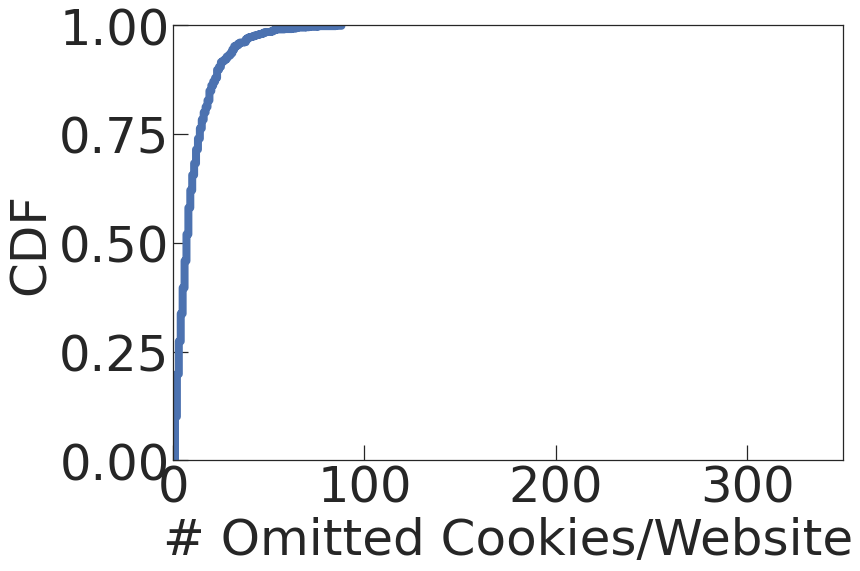

In [ ]:
sns.set(rc={'figure.figsize':(12,8),"font.size":35,"axes.titlesize":30,"axes.labelsize":50},style="white", font_scale = 4.5)
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

ax = sns.ecdfplot(data=omit_counts, x=omit_counts.num_omit_cookies, linewidth=8)
ax.set(xlim=(0, 350))

plt.xlabel('# Omitted Cookies/Website')
plt.ylabel('CDF')
# out_file = FIG_DIR / 'eu_omit_cookie_cdf.png'
# plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

Text(0.5, 0, 'Website')

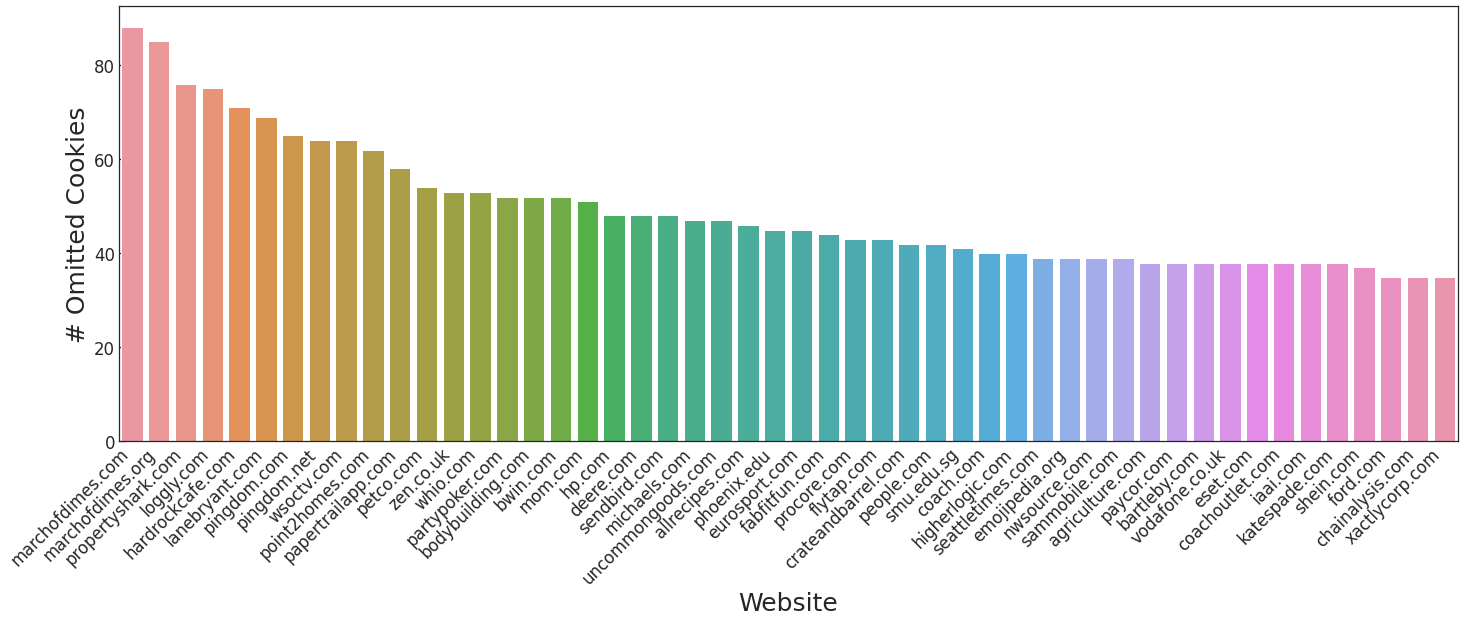

In [ ]:
plot_df = omit_counts[:50]

sns.set(rc={'figure.figsize':(24,8),"font.size":35,"axes.titlesize":35,"axes.labelsize":25},style="white", font_scale=1.5)
ax = sns.barplot(x=plot_df.index, y=plot_df.num_omit_cookies)
ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=False, direction="in")
ax.set_ylabel('# Omitted Cookies')
ax.set_xlabel('Website')

# out_file = FIG_DIR / 'omit_site.png'
# plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [ ]:
def plot_histogram_omit():
    sns.set(rc={'figure.figsize':(9,6),"font.size":25,"axes.titlesize":25,"axes.labelsize":15},style="white", font_scale = 1)
    omit_counts_histo = omit_complies.site.value_counts().value_counts()
    sns.barplot(x=omit_counts_histo.index, y=omit_counts_histo.values)
    ticks = plt.xticks(rotation=45, ha='right')

## Plot distribution of incorrectly enforced cookies

In [ ]:
incor_complies = complies[complies.comply == 'incorrect']
# set(cookielist_sites) - set(omit_complies.site.unique())
incor_counts = incor_complies.site.value_counts().iloc[:50]
incor_counts = incor_counts.to_frame().reset_index().sort_values(by=['site', 'index'], ascending=[False, True])
incor_counts.columns

Index(['index', 'site'], dtype='object')

Text(0.5, 0, 'Website')

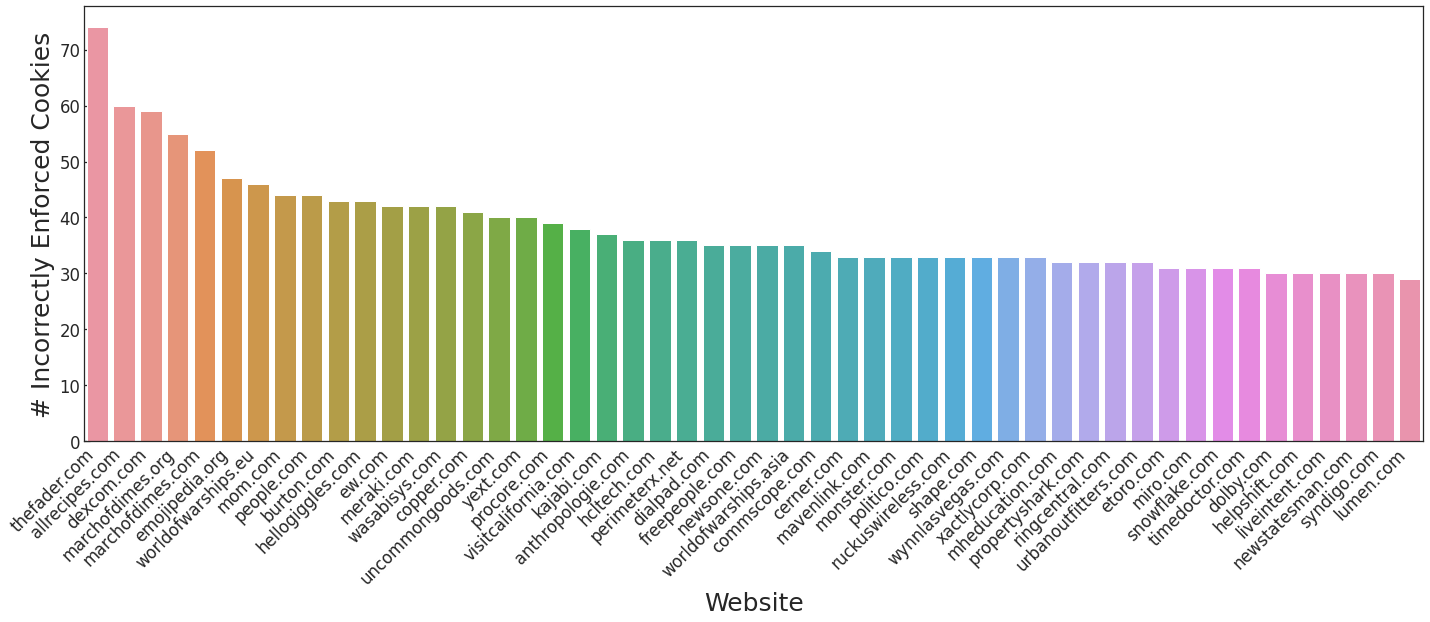

In [ ]:
sns.set(rc={'figure.figsize':(24,8),"font.size":35,"axes.titlesize":35,"axes.labelsize":25},style="white", font_scale=1.5)
ax = sns.barplot(x='index', y='site', data=incor_counts)

ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=True, direction="in")
ax.set_ylabel('# Incorrectly Enforced Cookies')
ax.set_xlabel('Website')

# out_file = FIG_DIR / 'incor_site.png'
# plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [ ]:
# len(incor_counts)

In [ ]:
incor_counts[incor_counts.site == 33].reset_index(drop=True)

,index,site
0,cerner.com,33
1,mavenlink.com,33
2,monster.com,33
3,politico.com,33
4,ruckuswireless.com,33
5,shape.com,33
6,wynnlasvegas.com,33
7,xactlycorp.com,33


### Top incorrect cookies

In [ ]:
incor_cookies = complies[complies.comply == 'incorrect']

In [ ]:
# site = 'onetrust.com'
# complies[complies.site == site].reset_index(drop=True)
# cookie_prefs[(cookie_prefs.site == site) & (cookie_prefs.name == '_gid')]

In [ ]:
top_incor_cookies = incor_cookies.name.value_counts().sort_values(ascending=False).to_frame().reset_index().rename(columns={'index':'cookie_name', 'name': 'num_occur'})

In [ ]:
top_incor_cookies['num_sites'] = top_incor_cookies.cookie_name.map(lambda cookie_name: incor_cookies[incor_cookies.name == cookie_name].site.nunique())

In [ ]:
print(top_incor_cookies.head(5)[['cookie_name', 'num_sites']].rename(columns={'cookie_name': 'Cookie Name', 'num_sites': '# Websites'}).to_latex(index=False))

\begin{tabular}{lr}
\toprule
Cookie Name &  \# Websites \\
\midrule
        \_ga &         523 \\
       \_gid &         497 \\
       lang &         204 \\
        IDE &         287 \\
       \_fbp &         287 \\
\bottomrule
\end{tabular}



# Narrow cookie consent preferences

In [ ]:
consent_cookies = sent_cookies[sent_cookies.name.isin(['OptanonConsent', 'CookieConsent'])][['domain', 'name', 'site']].drop_duplicates()
narrow_consent_cookies = consent_cookies[~consent_cookies.domain.str.startswith('.')].reset_index(drop=True)

In [ ]:
set(contra_cookies.site).intersection(set(narrow_consent_cookies.site))

{'returnpath.net', 'statista.com', 'suse.com'}

In [ ]:
narrow_consent_cookies

,domain,name,site
0,www.thule.com,OptanonConsent,thule.com
1,gb.benetton.com,CookieConsent,benetton.com
2,www.workaway.info,CookieConsent,workaway.info
3,www.mavenlink.com,CookieConsent,mavenlink.com
4,www.westminster-abbey.org,CookieConsent,westminster-abbey.org
...,...,...,...
165,owncloud.com,CookieConsent,owncloud.org
166,www.stackpath.com,CookieConsent,maxcdn.com
167,www.mandarinoriental.com,OptanonConsent,mandarinoriental.com
168,www.publitas.com,CookieConsent,publitas.com


# Case studies

In [ ]:
incor_df = complies[complies.comply == 'incorrect']
incor_df.site.value_counts().sort_values(ascending=False).head()

thefader.com        74
allrecipes.com      60
dexcom.com          59
marchofdimes.org    55
marchofdimes.com    52
Name: site, dtype: int64

In [ ]:
case_site = 'blabbermouth.net'
incor_df[incor_df.site == case_site]

,name,domain,site,comply


In [ ]:
# cookie_prefs[(cookie_prefs.site == 'scientificamerican.com') & (cookie_prefs.name == 'MXP_TRACKINGID')]
cookie_prefs[(cookie_prefs.site == case_site) & (cookie_prefs.name == 'IDE')]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent


In [ ]:
# sent_cookies[(sent_cookies.site == 'scientificamerican.com') & (sent_cookies.name == 'MXP_TRACKINGID')]

In [ ]:
omit_df = complies[complies.comply == 'omit']
omit_df.site.value_counts().sort_values(ascending=False).iloc[20:30]

deere.com             48
michaels.com          47
uncommongoods.com     47
allrecipes.com        46
phoenix.edu           45
eurosport.com         45
fabfitfun.com         44
procore.com           43
flytap.com            43
crateandbarrel.com    42
Name: site, dtype: int64

In [ ]:
print(omit_df[omit_df.site == 'scientificamerican.com'].reset_index().name.tolist())

['cfid', '_gcl_au', 'cftoken', 'optimizelyEndUserId', 'SA_fonts_loaded', '_gat', 'spw_ts', 'CF_SESSION_MURA1159D3CF4C8818EDC92155CA70EE9F5C', 'CF_SESSION_MURA1159D3CF4C8818EDC92155CA70EE9F5C_LV']


In [ ]:
'uids' in omit_df[omit_df.site == 'scientificamerican.com'].reset_index().name.tolist()

False

In [ ]:
omit_df[(omit_df.site == 'scientificamerican.com') & (omit_df.name == 'cftoken')]

,name,domain,site,comply
1441644,cftoken,.scientificamerican.com,scientificamerican.com,omit


In [ ]:
cookie_prefs[(cookie_prefs.site == 'scientificamerican.com') & (cookie_prefs.name == 'ADGRX_UID')]

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent


In [ ]:
all_sites = set(complies.site)
nothing_comply_sites = all_sites - set(complies[complies.comply == 'comply'].site)
print("Sites with no compliant cookies:", nothing_comply_sites)

Sites with no compliant cookies: {'kajabi.com', 'hersheys.com', 'contentstack.io', 'liveperson.net', 'vfsglobal.com', 'eurosport.com', 'widespace.com', 'shef.ac.uk', 'nielseniq.com', 'kew.org', 'givenchy.com', 'technicalseo.com', 'smartthings.com', 'thomson.com', 'keywordblocks.com', 'media.net', 'acm.org', 'appen.com', 'hightail.com', 'propertyshark.com', 'gmu.edu', 'thomsonreuters.com', 'warnerbros.com', 'accenture.com', 'liveperson.com', 'groove.co', 'heroku.com', 'nsf.org', 'wasabisys.com', 'okta-emea.com', 'fabfitfun.com', 'showtime.com', 'affordablecollegesonline.org', 'pokemon.com', 'userzoom.com', 'tlc.com', 'xrite.com', '24hourfitness.com', 'okta.com', 'infosys.com', 'mondelezinternational.com', 'klout.com', 'refinitiv.com', 'gameinformer.com', 'pentair.com', 'ingrammicro.com', 'mobileworldlive.com', 'ab-inbev.com', 'sheffield.ac.uk', 'ifc.com', 'lithium.com', 'ktm.com', 'centurylink.com', 'herokuapp.com', 'perimeterx.net', 'cerner.com', 'canvas.net', 'mom.com', 'dxc.technolog

In [ ]:
for site in ['liveperson.com']: # nothing_comply_sites:
    print(site)
site_cookies = postrej_br_cookies[postrej_br_cookies.site == site]

liveperson.com


NameError: name 'postrej_br_cookies' is not defined

In [ ]:
acookie = site_cookies[site_cookies.name == 'OptanonAlertBoxClosed'].iloc[0]

In [ ]:
site_prefs = cookie_prefs[cookie_prefs.site == site]
consent_cookies = site_prefs[site_prefs.consent]
consent_cookie_names = consent_cookies.name
site_cookies[site_cookies.name.isin(consent_cookie_names)]
# cookie_name = 'OptanonAlertBoxClosed'
# cookie_pref = site_prefs[site_prefs.name == cookie_name].iloc[0]
# cookie_pref

In [ ]:
consent_cookies

In [ ]:
import sys; import importlib; importlib.reload(sys.modules['consent.consistency.cookie_pref_match'])
from consent.consistency.cookie_pref_match import cookie_pref_match    
cookie_pref_match(acookie, cookie_pref, site, verbose=2)

In [ ]:
# Analyze Contras